In [82]:
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass


# helper functions 
from importlib import reload 
import module 

### Plotting function

In [ ]:

# Inputs: arrays of annual discounted costs for EV and ICE, and length of time to plot
# Outputs: line plot of cumulative costs (discounted) of EV and ICE over time period
def plot_cumulative_costs(EV, ICE):
    costs_EV = EV.get_annual_discounted_costs()
    costs_ICE = ICE.get_annual_discounted_costs()
    years  = np.arange(0, len(costs_EV))
    plt.title("Cumulative Costs ($), \n EV (retrofit) vs ICE (refurbished)", size = 18)
    plt.xlabel("Years")
    plt.ylabel("Cost ($)")
    plt.plot(years[1:], np.cumsum(costs_EV[1:]), color = 'blue', label = 'EV', marker = 'o')
    plt.plot(years[1:], np.cumsum(costs_ICE[1:]), color = 'red', label = 'ICE', marker = 'o')
    plt.legend()
    plt.show()

# TODO: 

(in no particular order)
1. <font color = 'yellow'> Read in parameters as data load in or user input. </font>
1. <font color = 'red'> Upgrade the EV charge simulation, possibly based on data or heuristics (needs a discussion) </font>
2. <font color = 'orange'> Currently hard-coded as year on year analysis, may want to make this dynamic </font>
3. <font color = 'orange'> Include end of life EV value somehow </font> 
4. <font color = 'yellow'> Include rebuy cost for the vehicle with the shorter lifespan in the main function? </font>
5. <font color = 'yellow'> Amortization schedule function is clunk so fix. No need for pandas df </font>

key: 
<font color = 'red'> hard </font>,
<font color = 'orange'> medium </font>,
<font color = 'yellow'> easy </font> </br>

# Classes

### Data classes
In practice, to be instantiated with user input or loaded data

In [352]:
@dataclass
class ChargingPort: 
    charging_power: float 
    charging_efficiency: float 
    capex: float 

@dataclass 
class MarketEnvironment:
    interest_rate: float 
    inflation_rate: float 
    price_diesel: float 
    price_electricity: float 
    time_of_use_tariffs: dict
    time_periods: dict
    price_diesel_annual_growth_rate: float 
    price_electricity_annual_growth_rate: float 
    discount_rate: float 
 
@dataclass    
class FinancingMechanism:
    loan_lifetime: int 
    installment_schedule: int 
    

### Vehicle 
(for ICE vehicles / parent class of EV alternative)

In [307]:
class Vehicle:
    KGCO2EQ_PER_L_DIESEL = 2.3 # kgCO2/L
    
    def __init__(self, model: str, params: dict, market_environment, financing_mechanism):
    
        self.model = model
        self.daily_mileage = params['daily_mileage'] # km/day
        self.days_worked_per_week = params['days_worked_per_week'] # days/week
        self.weeks_worked_per_year = params['weeks_worked_per_year'] # weeks/year
        self.fuel_economy = params['fuel_economy'] # L/100km
        self.service_life = params['service_life'] # years
        self.capex = params['ICE_capex'] # $/vehicle
        self.down_payment = params['down_payment_fraction'] * self.capex # $/vehicle
        
        # Other operating costs
        self.annual_maintenance_cost = params['annual_maintenance_cost'] # $/year
        self.annual_insurance_cost = params['annual_insurance_cost'] # $/year
        self.annual_taxes = params['annual_taxes'] # $/year
        
        # data classes
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
        
    def __repr__(self):
        return f"ICE(id = {repr(self.model)}, daily_mileage = {repr(self.daily_mileage)}, days_worked_per_week = {repr(self.days_worked_per_week)}, weeks_worked_per_year = {repr(self.weeks_worked_per_year)}, fuel_economy = {repr(self.fuel_economy)}, annual_maintenance_cost = {repr(self.annual_maintenance_cost)})"  
        
    
    ### Computed properties
    @property
    def loan_amount(self):
        return self.capex - self.down_payment
    
    @property
    def annual_mileage(self):
        return self.daily_mileage * self.days_worked_per_week * self.weeks_worked_per_year
    
    @property 
    def annual_fuel_consumption(self):
        return self.annual_mileage * self.fuel_economy / 100
    
    @property 
    def annual_carbon_emissions(self):
        return self.annual_fuel_consumption * Vehicle.KGCO2EQ_PER_L_DIESEL
    
    # Costs
    @property 
    def amortization_schedule(self):
        loan_amount = -self.loan_amount
        interest_rate_per_period = self.market_environment.interest_rate / self.financing_mechanism.installment_schedule
        periods = self.financing_mechanism.loan_lifetime * self.financing_mechanism.installment_schedule # monthly payback
        n_periods = np.arange(periods) + 1
    
        ##### BUILD AMORTIZATION SCHEDULE #####
        # Interest 
        interest_monthly = npf.ipmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Principal 
        principal_monthly = npf.ppmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Join data in dataframe
        df = pd.DataFrame({
            'Period': n_periods,
            'Interest': interest_monthly,
            'Principal': principal_monthly
        })
    
        # Monthly Loan Payment
        df['Payment'] = df['Interest'] + df['Principal']
    
        # Cumsum Loan Payments
        df['Balance'] = df['Payment'].cumsum()
    
        # Reverse vals to pay down balance
        df['Balance'] = df['Balance'].values[::-1]
    
        return df
    
    @property 
    def capital_financing_costs(self):
        cap_fin_cost = np.zeros(self.financing_mechanism.loan_lifetime)
        cap_fin_cost[0] = -self.capex
        annual_loan_payment = self.amortization_schedule.iloc[0:self.financing_mechanism.installment_schedule].sum()['Payment']
        cap_fin_cost[1:self.financing_mechanism.loan_lifetime + 1] = annual_loan_payment
        return cap_fin_cost
    
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.market_environment.price_diesel * self.annual_fuel_consumption)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_diesel_annual_growth_rate)**(idx-1)
        
        return operating_cost_fuel

    @property
    def operating_cost_other(self):
        operating_cost_other = np.full(self.service_life, self.annual_insurance_cost + self.annual_maintenance_cost + self.annual_taxes)
        operating_cost_other[0] = 0 # 0 operating costs in year 0 (before the purchase is made)
        
        return operating_cost_other
    
    @property
    def operating_cost_total(self):
        return self.operating_cost_fuel + self.operating_cost_other
    
    @property
    def annual_costs(self):
        # identify which list is shorter between self.capital_financing_Costs and self.operating_Cost_total
        # if self.capital_financing_costs is shorter, pad it with zeros
        # if self.operating_cost_total is shorter, pad it with zeros
        # sum the two lists
        # return the sum
        
        capital_financing_costs = self.capital_financing_costs
        operating_cost_total = self.operating_cost_total
        
        if len(capital_financing_costs) <= len(operating_cost_total):
            capital_financing_costs = np.pad(capital_financing_costs, (0, len(operating_cost_total) - len(capital_financing_costs)), 'constant')
        else:
            operating_cost_total = np.pad(operating_cost_total, (0, len(capital_financing_costs) - len(operating_cost_total)), 'constant')
        
    
        return [cap_fin_cost + op_cost for cap_fin_cost, op_cost in zip(capital_financing_costs, operating_cost_total)]
    
    
    def get_annual_discounted_costs(self):
            
        cost_annual_discounted = self.annual_costs
        
        for year in range(len(cost_annual_discounted)):
            cost_annual_discounted[year] = cost_annual_discounted[year] * (1/(1+self.market_environment.discount_rate))**year
    
        return cost_annual_discounted
    
    # TODO: Add depreciation schedule
    def get_end_of_life_value(self):   
        return 0
    

### EV subclass

In [369]:
class EV(Vehicle):
    GRID_CARBON_INTENSITY = 0.95 # kgCO2/kWh
    

    def __init__(self, model: str, params: dict, charging_port, market_environment, financing_mechanism):
        super().__init__(model, params, market_environment, financing_mechanism)
        self.model = model # string
        self.efficiency = params['efficiency'] # kWh/km
        self.battery_capacity = params['battery_capacity'] # kWh
        
        self._first_EV = params['firstEV'] # boolean
        self._charging_profile = None # kWh
        
        
        # data classes
        self.charging = charging_port
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
        if self._first_EV:
            self.capex = params['EV_capex'] + self.charging.capex # $
        else:
            self.capex = params['EV_capex'] # $
            
        
        
    def __repr__(self):
        return f"EV(id={repr(self.model)}, battery_capacity={repr(self._battery_capacity)}, charging_power={repr(self.charging.charging_power)})"
    
    
    # Efficiency getter and setter (for later on when we want to be able to change efficiency of vehicle and have it affect the charging profile without reinstantiating class)
    @property
    def efficiency(self):
        return self._efficiency
    
    @efficiency.setter
    def efficiency(self, efficiency):
        self._charging_profile = None
        self._efficiency = efficiency
        
    # Battery capacity getter and setter
    @property 
    def battery_capacity(self):
        return self._battery_capacity
    
    @battery_capacity.setter
    def battery_capacity(self, battery_capacity):
        self._charging_profile = None # reset charging profile when battery capacity is changed 
        self._battery_capacity = battery_capacity
    
        
        
    # Charging profile (simulated or data loaded)
    @property 
    def charging_profile(self):
        # cache 
        if self._charging_profile is None: # cache when not None 
            total_days = 365  # Total number of days to simulate
            total_time = 24 * total_days  # Total simulation time in hours
            time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
            self._charging_profile = module.simulate_charging_load_profile(total_days, total_time, time_resolution, 1, self.charging.charging_power, plot = False)
        return self._charging_profile
        
    # Monetary costs
    @property
    def annual_electricity_costs(self):
        return module.get_cost_of_charging(self.charging_profile, self.market_environment.time_of_use_tariffs, self.market_environment.time_periods)
        
        
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.annual_electricity_costs)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_electricity_annual_growth_rate)**(idx-1)
                

        return operating_cost_fuel


    # Carbon emissions 
    @property 
    def annual_carbon_emissions(self):
        kWh_used = sum(self.charging_profile)
        return kWh_used * EV.GRID_CARBON_INTENSITY
    


        

# Main

## Initialize parameters 
(in future to be user input or loaded from data file)

In [ ]:
vehicle_params = {'daily_mileage': 100, 'days_worked_per_week': 5, 'weeks_worked_per_year': 50, 'fuel_economy': 10, 'service_life': 10, 
                  'down_payment_fraction': 0.2, 'annual_maintenance_cost': 1000, 'annual_insurance_cost': 1000, 'annual_taxes': 1000, 
                  'efficiency': 0.2, 'battery_capacity': 30, 
                  'EV_capex': 20000, 
                  'ICE_capex': 10000,
                  'firstEV': False} # if True, then include the charging port capex

charging_port_params = {'charging_power': 7.2, 'charging_efficiency': 0.9, 'capex': 10000}

market_params = {'price_electricity': 0.08, 'price_electricity_annual_growth_rate': 0.02, 
                 'price_diesel': 1.20, 'price_diesel_annual_growth_rate': 0.10, 
                 'discount_rate': 0.10, 'inflation_rate': 0.02,
                 'interest_rate': 0.07,
                 'time_of_use_tariffs': {'morning': 0.10, 'afternoon': 0.15, 'evening': 0.20, 'night': 0.10},
                 'time_periods': {'morning_start': 5, 'afternoon_start': 11, 'evening_start': 17, 'night_start': 21}}

financing_params = {'loan_lifetime': 5, 'installment_schedule': 12}


## Instantiate classes

In [373]:
reload(module)

charging_port1 = ChargingPort(**charging_port_params)
market_environment1 = MarketEnvironment(**market_params)
financing_mechanism1 = FinancingMechanism(**financing_params)  


vehicle1 = Vehicle(1, vehicle_params, market_environment = market_environment1, financing_mechanism = financing_mechanism1)
ev1 = EV(vehicle1, vehicle_params, charging_port1, market_environment1, financing_mechanism1)


## Results

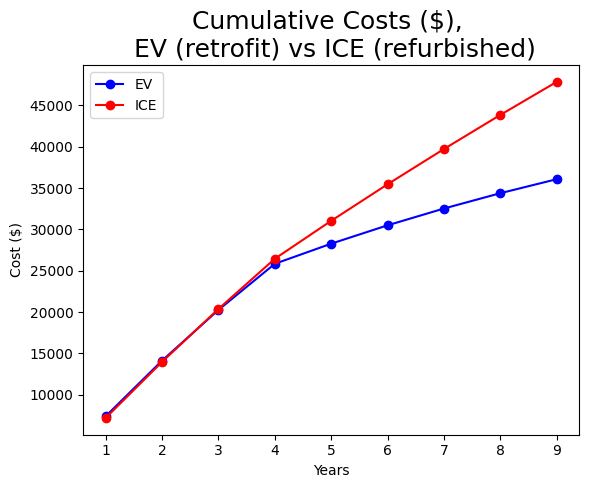

In [375]:
plot_cumulative_costs(ev1, vehicle1)
plt.show()



In [382]:
print("ICEV emits: ", round(vehicle1.annual_carbon_emissions, 2), "kgCO2eq/year")
print("EV emits: ", round(ev1.annual_carbon_emissions, 2), "kgCO2eq/year")

ICEV emits:  5750.0 kgCO2eq/year
EV emits:  6224.4 kgCO2eq/year
